# Outline
    preprocessing
        impute base on 2 hour avg
        shift 1 - 12 columns
        feature engineering
    trainning
        model (Nested CV) for each hour, drop specific columns since pm2.5 column with missing value are different for each hour
            Stack
                knn
                rf
                LR
                XGBoost
                SVM

In [38]:
import pandas as pd

file_path = 'data/data.csv'
data = pd.read_csv(file_path, index_col=0)

## data visuallization

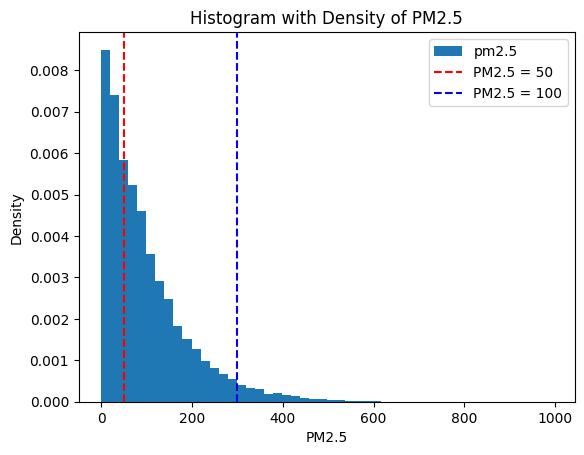

In [39]:
import matplotlib.pyplot as plt

# Adjusted the number of bins to be finer (thinner) by increasing the number
data['pm2.5'].plot(kind='hist', bins=50, density=True, title='Histogram with Density of PM2.5')
plt.xlabel('PM2.5')
plt.ylabel('Density')
plt.axvline(x=50, color='r', linestyle='--', label='PM2.5 = 50')
plt.axvline(x=300, color='b', linestyle='--', label='PM2.5 = 100')
plt.legend()
plt.show()

In [40]:
# Calculate the percentage of pm2.5 values greater than or equal to 50
pm25_gte_50 = (data['pm2.5'] >= 50).mean() * 100
print(f"Percentage of PM2.5 values >= 50: {pm25_gte_50:.2f}%")

# Calculate the percentage of pm2.5 values greater than or equal to 100
pm25_gte_100 = (data['pm2.5'] >= 300).mean() * 100
print(f"Percentage of PM2.5 values >= 300: {pm25_gte_100:.2f}%")

Percentage of PM2.5 values >= 50: 59.49%
Percentage of PM2.5 values >= 300: 4.05%


In [41]:
daily_hour_counts = data.groupby(['year', 'month', 'day']).size()
missing_hours = daily_hour_counts[daily_hour_counts != 24]
missing_hours
# no missing hours

Series([], dtype: int64)

## preprocessing

In [42]:
data['pm2.5'] = data['pm2.5'].interpolate()

In [43]:
# Creating 12 new columns for future PM2.5 levels, 1 hour to 12 hours ahead
for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

# One-hot encode the 'cbwd' column
data = pd.get_dummies(data, columns=['cbwd'])

In [44]:
# Calculate the total number of rows with any missing values before dropping
missing_rows_before = data.isna().any(axis=1).sum()
print(f'missing rows before: {missing_rows_before}')
# Drop rows where any cell from 'pm2.5' to 'pm2.5_12_hour_after' is missing
data.dropna(subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)], inplace=True)

missing rows before: 36


In [45]:
# Calculate the index to split the data at 85% for training and 15% for testing
split_index = int(len(data) * 0.85)

# Split the data into training and test sets
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

# Displaying sizes of the new datasets
print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

Training Data Size: 37219
Test Data Size: 6569


In [46]:
print(data_train.isnull().sum())

year                   0
month                  0
day                    0
hour                   0
pm2.5                  0
DEWP                   0
TEMP                   0
PRES                   0
Iws                    0
Is                     0
Ir                     0
pm2.5_1_hour_after     0
pm2.5_2_hour_after     0
pm2.5_3_hour_after     0
pm2.5_4_hour_after     0
pm2.5_5_hour_after     0
pm2.5_6_hour_after     0
pm2.5_7_hour_after     0
pm2.5_8_hour_after     0
pm2.5_9_hour_after     0
pm2.5_10_hour_after    0
pm2.5_11_hour_after    0
pm2.5_12_hour_after    0
cbwd_NE                0
cbwd_NW                0
cbwd_SE                0
cbwd_cv                0
dtype: int64


In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


# Prepare training and test data (drop the labels and year columns)
X_train = data_train.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

# Define numerical columns (replace these with the actual numerical column names in your dataset)
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# ColumnTransformer to normalize numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # Normalize numerical columns
    ],
    remainder='passthrough'  # Keep other columns as is
)

## training
    Note: the models in the notebook are fitted only once using predetermined hyperparameters from NestedCV, code with NCV are included also as scripts

In [48]:
# Initialize a list of dictionaries with predefined keys and None as placeholder values
best_models = [{"RF": None, "XGBoost": None, "SVC": None, "Logistic": None, "KNN": None} for i in range(12)]

In [ ]:
"""XGBoost with no cv"""

In [ ]:
# Output overall averaged results
# Note: Since we appended both nested CV averages and test metrics, the length of f1_scores and roc_aucs is double the number of hours
avg_f1_nested = np.mean(f1_scores[:num_hours])
avg_roc_auc_nested = np.mean(roc_aucs[:num_hours])
avg_f1_test = np.mean(f1_scores[num_hours:])
avg_roc_auc_test = np.mean(roc_aucs[num_hours:])

print(f"\nAveraged Nested CV F1 Score across {num_hours} hours: {avg_f1_nested:.2f}")
print(f"Averaged Nested CV ROC-AUC across {num_hours} hours: {avg_roc_auc_nested:.2f}")
print(f"Averaged Test F1 Score across {num_hours} hours: {avg_f1_test:.2f}")
print(f"Averaged Test ROC-AUC across {num_hours} hours: {avg_roc_auc_test:.2f}")


Averaged Nested CV F1 Score across 12 hours: 0.91
Averaged Nested CV ROC-AUC across 12 hours: 0.94
Averaged Test F1 Score across 12 hours: 0.84
Averaged Test ROC-AUC across 12 hours: 0.85


In [52]:
for i, model_dict in enumerate(best_models):
    if model_dict['XGBoost'] is not None:
        print(f"Best parameters for XGBoost model {i + 1} hours after:")
        best_params = model_dict['XGBoost'].get_params()
        for param in param_grid.keys():
            print(f"{param}: {best_params[param]}")
    else:
        print(f"No XGBoost model found for {i + 1} hours after.")

Best parameters for XGBoost model 1 hours after:
classifier__n_estimators: 100
classifier__max_depth: 3
classifier__learning_rate: 0.1
Best parameters for XGBoost model 2 hours after:
classifier__n_estimators: 200
classifier__max_depth: 3
classifier__learning_rate: 0.05
Best parameters for XGBoost model 3 hours after:
classifier__n_estimators: 300
classifier__max_depth: 3
classifier__learning_rate: 0.05
Best parameters for XGBoost model 4 hours after:
classifier__n_estimators: 200
classifier__max_depth: 3
classifier__learning_rate: 0.05
Best parameters for XGBoost model 5 hours after:
classifier__n_estimators: 200
classifier__max_depth: 3
classifier__learning_rate: 0.05
Best parameters for XGBoost model 6 hours after:
classifier__n_estimators: 200
classifier__max_depth: 3
classifier__learning_rate: 0.05
Best parameters for XGBoost model 7 hours after:
classifier__n_estimators: 200
classifier__max_depth: 3
classifier__learning_rate: 0.05
Best parameters for XGBoost model 8 hours after:


1 hours after: Test F1 Score: 0.95, Test ROC-AUC: 0.98
2 hours after: Test F1 Score: 0.92, Test ROC-AUC: 0.96
3 hours after: Test F1 Score: 0.89, Test ROC-AUC: 0.94
4 hours after: Test F1 Score: 0.87, Test ROC-AUC: 0.91
5 hours after: Test F1 Score: 0.85, Test ROC-AUC: 0.89
6 hours after: Test F1 Score: 0.85, Test ROC-AUC: 0.87
7 hours after: Test F1 Score: 0.84, Test ROC-AUC: 0.85
8 hours after: Test F1 Score: 0.83, Test ROC-AUC: 0.84
9 hours after: Test F1 Score: 0.82, Test ROC-AUC: 0.82
10 hours after: Test F1 Score: 0.81, Test ROC-AUC: 0.80
11 hours after: Test F1 Score: 0.80, Test ROC-AUC: 0.79
12 hours after: Test F1 Score: 0.79, Test ROC-AUC: 0.77


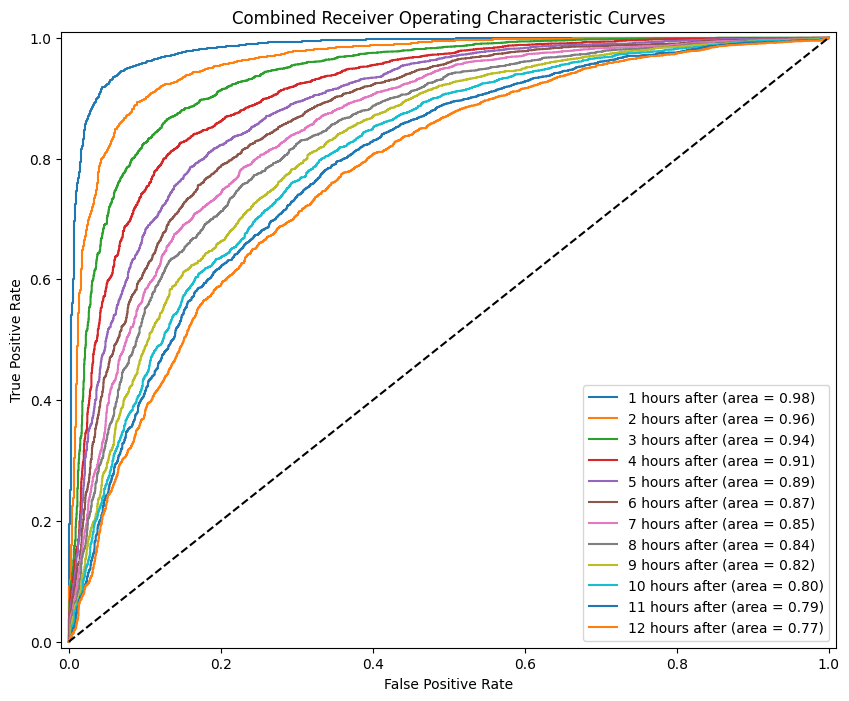

Averaged F1 Score: 0.85
Averaged ROC-AUC: 0.87


In [53]:
"""Logistic Regression"""
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt

# Initialize lists to store results for each hour
f1_scores = []
roc_aucs = []

# Create a single plot for all ROC curves
plt.figure(figsize=(10, 8))

# Use tqdm to add a progress bar to the loop
for i in range(1, 13):
    # The current ith hour after current hour as label
    y_train = data_train[f'pm2.5_{i}_hour_after'] >= 50
    y_test = data_test[f'pm2.5_{i}_hour_after'] >= 50

    # Create a pipeline with preprocessing and the Logistic Regression model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Normalize numerical columns
        ('classifier', LogisticRegression(max_iter=1000, random_state=1))  # Logistic Regression model
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions on the test data
    y_pred_test = pipeline.predict(X_test)
    y_prob_test = pipeline.predict_proba(X_test)[:, 1]

    # Calculate scores for the test data
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Store the results
    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    # Output the test F1 Score and ROC-AUC for the current hour
    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    # ROC Curve for test data
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

    # Plot the ROC curve on the single plot
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (area = {roc_auc_test:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Configure plot
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")
plt.show()

# Output overall results
print(f"Averaged F1 Score: {sum(f1_scores)/len(f1_scores):.2f}")
print(f"Averaged ROC-AUC: {sum(roc_aucs)/len(roc_aucs):.2f}")


In [54]:
"""Support Vector Classifier (SVC)"""
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt

# Prepare training and test data (drop the labels and 'year' column)
X_train = data_train.drop(
    columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year']
)
X_test = data_test.drop(
    columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year']
)

# Define numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# ColumnTransformer to preprocess numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Normalize numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # One-hot encode categorical columns
    ]
)

# Initialize lists to store results for each hour
f1_scores = []
roc_aucs = []

# Create a single plot for all ROC curves
plt.figure(figsize=(10, 8))

for i in range(1, 13):
    # The current ith hour after current hour as label
    y_train = data_train[f'pm2.5_{i}_hour_after'] >= 50
    y_test = data_test[f'pm2.5_{i}_hour_after'] >= 50

    # Create a pipeline with preprocessing and the SVC model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Preprocess features
        ('classifier', SVC(kernel='rbf', probability=True, random_state=1))  # SVC with RBF kernel
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions on the test data
    y_pred_test = pipeline.predict(X_test)
    y_prob_test = pipeline.predict_proba(X_test)[:, 1]

    # Calculate scores for the test data
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    # Store the results
    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    # Output the test F1 Score and ROC-AUC for the current hour
    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    # ROC Curve for test data
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

    # Plot the ROC curve on the single plot
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (area = {roc_auc_test:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Configure plot
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")
plt.show()

# Output overall results
print(f"Averaged F1 Score: {sum(f1_scores)/len(f1_scores):.2f}")
print(f"Averaged ROC-AUC: {sum(roc_aucs)/len(roc_aucs):.2f}")


KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>